# Project 1: Data Collection and Exploratory Data Analysis

### <i> Data: Major figures from Classic Hollywood cinema <i>

<b> Description </b>: The objective of this project is to showcase the skills related to data collection, data preprocessing, and exploratory data analysis. </br>
As the aim for my data collection practice I chose the list called "Major figures from Classic Hollywood cinema" from a Wikipedia page. The motivation behind the choice is easy to explain: (1) Old Hollywood cinema is something that I'm passionate about, and (2) the dataset I build duing this project appears to be quite unique, which underlines its originality. </br>
- In the first section of this project, I scrape data from the above-mentioned Wikipedia webpage using BeautifulSoup library and handle all the mess that comes my way.</br>
- In the second section, I clean up and preprocess all the data I collected previously using Pandas data frames and Regex library.
- In the third section, I perform some data analysis and visualize the results in order to gain some interesting insights about the Old Hollywood figures.

<img src="Hollywood.jpg" alt="Golden Age of Hollywood" />

## 1. Data Collection </h1>

#### Import necessary libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
import re

import warnings
warnings.filterwarnings('ignore')

#### Load a webpage of a single figure from the list

In [94]:
wp = requests.get("https://en.wikipedia.org/wiki/Carmen_Miranda")

# Convert to a beautiful soup object
soup = bs(wp.content)

#### Extract necessary data from the infobox

In [95]:
info_box = soup.find(class_=["infobox biography vcard","infobox vcard"])
table_rows = info_box.find_all("tr")

# Print out the HTML
for row in table_rows:
    print(row.prettify())

<tr>
 <th class="infobox-above" colspan="2" style="font-size:125%;">
  <div class="fn" style="display:inline">
   Carmen Miranda
  </div>
  <br/>
  <div class="honorific-suffix" style="font-size: 77%; font-weight: normal; display:inline;">
   <a href="/wiki/Order_of_Prince_Henry" title="Order of Prince Henry">
    GCIH
   </a>
   •
   <a href="/wiki/Ordem_do_M%C3%A9rito_Cultural" title="Ordem do Mérito Cultural">
    OMC
   </a>
  </div>
 </th>
</tr>

<tr>
 <td class="infobox-image" colspan="2">
  <a class="image" href="/wiki/File:Carmen_Miranda_1941.JPG">
   <img alt="A smiling Carmen Miranda against a bamboo wall" data-file-height="1245" data-file-width="957" decoding="async" height="286" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Carmen_Miranda_1941.JPG/220px-Carmen_Miranda_1941.JPG" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Carmen_Miranda_1941.JPG/330px-Carmen_Miranda_1941.JPG 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Carmen_Miranda_1

In [96]:
# Create a function that eliminates common messy spots and returns a string value
def get_clean_values(table_rows):
    if table_rows.find("li"):
        return table_rows.find(class_=["plainlist", "hlist"]).get_text(", ", strip=True).replace("\xa0", " ").replace("\u200b", " ")
    else:
        return table_rows.get_text(", ", strip=True).replace("\xa0", " ").replace("\u200b", " ")

# Create a function to strip out superscripts (references) from our code
def clean_tags(soup):
    for sup in soup.find_all("sup"):
        sup.decompose()

clean_tags(soup)
        
# Iterate over table rows of our infobox and put the data into a dictionary
actors_info = {}

for index, row in enumerate(table_rows):
    if index == 0:
        actors_info['Name'] = get_clean_values(row.find(class_="fn"))
        name_var = actors_info['Name']
    elif index == 1:
        continue
    elif index == 2:
       # Handle edgy cases
        try:
            actors_info['Full Birth Name'] = get_clean_values(row.find(class_="nickname"))
        except Exception as e:
            print(f"Error getting Full Birth Name: {e}")
        try:
            actors_info['Birth Date'] = get_clean_values(row.find(class_="bday"))
        except:
            # Use Regex to handle some unusual birth dates
            try:
                reg = r'(,.*,\s\d{4})'
                match = re.findall(reg, get_clean_values(row.find(class_="infobox-data")))
                match = match[0]
                match = re.search(r',\s*(.*)', match)
                if match:
                    match = match.group(1)    
                actors_info['Birth Date'] = match
            except Exception as e:
                print(f"Error getting Birth Date: {e}")     
        try:
            actors_info['Place of Birth'] = get_clean_values(row.find(class_="birthplace"))
        except Exception as e:
            print(f"Error getting Place of Birth: {e}")
    elif index == 3:
        try:
            actors_info['Died'] = get_clean_values(row.select_one("span")).replace("(", "").replace(")", "")
        except Exception as e:
            print(f"Error getting Date of Death: {e}")
        try:
            actors_info['Death Place'] = get_clean_values(row.find(class_="deathplace"))
        except Exception as e:
            print(f"Error getting Death Place: {e}")
    else:
        try:
            info_key = get_clean_values(row.find("th"))
            info_value = get_clean_values(row.find("td"))
            actors_info[info_key] = info_value
        except:
            continue

actors_info

{'Name': 'Carmen Miranda',
 'Full Birth Name': 'Maria do Carmo Miranda da Cunha',
 'Birth Date': '1909-02-09',
 'Place of Birth': 'Marco de Canaveses, ,, Kingdom of Portugal',
 'Died': '1955-08-05',
 'Death Place': 'Beverly Hills, California, , U.S.',
 'Resting place': 'São João Batista Cemetery, , Rio de Janeiro, Brazil',
 'Other names': 'The Brazilian Bombshell, The Chiquita Banana Girl, A Pequena Notável, (in Brazil)',
 'Education': 'Convent of Saint Therese of Lisieux',
 'Occupations': 'Singer, dancer, actress',
 'Years active': '1928–1955',
 'Spouse': 'David Alfred Sebastian,  ,  , (, m., 1947),  ',
 'Relatives': 'Amaro da Cunha, (brother), Aurora Miranda, (sister), Cecilia Miranda de Carvalho, (sister)',
 'Genres': 'Samba',
 'Instrument(s)': 'Vocals',
 'Labels': 'RCA, Brunswick Records, EMI-Odeon, Decca Records, PolyGram',
 'Website': 'www, .carmenmiranda, .com, .br'}

#### Get infoboxes for all figures

In [97]:
# Create a function for standardized extraction of infoboxes using the code above
def get_infobox(url):
    
    wp = requests.get(url)
    soup = bs(wp.content)
    info_box = soup.find(class_=["infobox biography vcard","infobox vcard"])
    table_rows = info_box.find_all("tr")
    clean_tags(soup)
    
    figure_info = {}
    for index, row in enumerate(table_rows):
        if index == 0:
            figure_info['Name'] = get_clean_values(row.find(class_="fn"))
            name_var = figure_info['Name']
        elif index == 1:
            continue
        elif index == 2:
            try:
                figure_info['Full Birth Name'] = get_clean_values(row.find(class_="nickname"))
            except Exception as e:
                print(f"Error getting Full Birth Name for {name_var}: {e}")
            try:
                figure_info['Birth Date'] = get_clean_values(row.find(class_="bday"))
            except:
                try:
                    reg = r'(,.*,\s\d{4})'
                    match = re.findall(reg, get_clean_values(row.find(class_="infobox-data")))
                    match = match[0]
                    match = re.search(r',\s*(.*)', match)
                    if match:
                        match = match.group(1)
                    figure_info['Birth Date'] = match
                except Exception as e:
                    print(f"Error getting Birth Date for {name_var}: {e}")  
            try:
                figure_info['Place of Birth'] = get_clean_values(row.find(class_="birthplace"))
            except Exception as e:
                print(f"Error getting Place of Birth for {name_var}: {e}")
        elif index == 3:
            try:
                figure_info['Died'] = get_clean_values(row.select_one("span")).replace("(", "").replace(")", "")
            except Exception as e:
                print(f"Error getting Date of Death for {name_var}: {e}")
            try:
                figure_info['Death Place'] = get_clean_values(row.find(class_="deathplace"))
            except Exception as e:
                print(f"Error getting Death Place for {name_var}: {e}")
        else:
            try:
                info_key = get_clean_values(row.find("th"))
                info_value = get_clean_values(row.find("td"))
                figure_info[info_key] = info_value
            except:
                continue
        
    return figure_info

In [98]:
get_infobox("https://en.wikipedia.org/wiki/Julie_Andrews")

Error getting Date of Death for Julie Andrews: 'NoneType' object has no attribute 'find'
Error getting Death Place for Julie Andrews: 'NoneType' object has no attribute 'find'


{'Name': 'Julie Andrews',
 'Full Birth Name': 'Julia Elizabeth Wells',
 'Birth Date': '1935-10-01',
 'Place of Birth': 'Walton-on-Thames, ,, Surrey, , England',
 'Years active': '1945–present',
 'Works': 'Full list',
 'Spouses': 'Tony Walton,  ,  , (, m., 1959;, div., 1968),  , Blake Edwards,  ,  , (, m., 1969; died 2010),  ',
 'Children': '5, including, Emma Walton Hamilton',
 'Awards': 'Full list'}

In [99]:
# Load the HTML list of all major figures' infoboxes
wb_l = requests.get("https://en.wikipedia.org/wiki/Classical_Hollywood_cinema")
soup_l = bs(wb_l.content)

figures = soup_l.select(".div-col")
figures = figures[0].select("li")

figures

[<li><a href="/wiki/Carl_Laemmle" title="Carl Laemmle">Carl Laemmle</a> (1867–1939)</li>,
 <li><a href="/wiki/Marie_Dressler" title="Marie Dressler">Marie Dressler</a> (1868–1934)</li>,
 <li><a href="/wiki/Adolph_Zukor" title="Adolph Zukor">Adolph Zukor</a> (1873–1976)</li>,
 <li><a href="/wiki/D._W._Griffith" title="D. W. Griffith">D. W. Griffith</a> (1875–1948)</li>,
 <li><a href="/wiki/Lionel_Barrymore" title="Lionel Barrymore">Lionel Barrymore</a> (1878–1954)</li>,
 <li><a class="mw-redirect" href="/wiki/Max_Factor_(person)" title="Max Factor (person)">Max Factor</a> (1877–1938)</li>,
 <li><a href="/wiki/Cecil_B._DeMille" title="Cecil B. DeMille">Cecil B. DeMille</a> (1881–1959)</li>,
 <li><a href="/wiki/Samuel_Goldwyn" title="Samuel Goldwyn">Samuel Goldwyn</a> (1882–1974)</li>,
 <li><a href="/wiki/John_Barrymore" title="John Barrymore">John Barrymore</a> (1882–1942)</li>,
 <li><a href="/wiki/Lon_Chaney" title="Lon Chaney">Lon Chaney</a> (1883–1930)</li>,
 <li><a href="/wiki/Dougla

In [100]:
len(figures)

196

In [101]:
# Loop over the HTML list to get the final list with dictionaries for all figures' infoboxes
base_path = "https://en.wikipedia.org"

figures_info = []
for index, figure in enumerate(figures):
    try: 
        rel_path = figure.a['href']
        full_path = base_path + rel_path
        name = figure.a['title']
        figures_info.append(get_infobox(full_path))
    except Exception as e:
        print(f"Error getting relative path of the following figures' webpages: {e}")
    if index % 10 == 0:
        print(index)
        
# Note 1: raising exceptions is for debugging purposes;
# Note 2: some values are missing and it's OK.

0
Error getting Full Birth Name for Adolph Zukor: 'NoneType' object has no attribute 'find'
10
Error getting Birth Date for Louis B. Mayer: list index out of range
Error getting Full Birth Name for Sessue Hayakawa: 'NoneType' object has no attribute 'find'
Error getting Birth Date for Sessue Hayakawa: 'NoneType' object has no attribute 'find'
Error getting Place of Birth for Sessue Hayakawa: 'NoneType' object has no attribute 'find'
Error getting Death Place for Sessue Hayakawa: 'NoneType' object has no attribute 'find'
Error getting Birth Date for Groucho Marx: list index out of range
Error getting Place of Birth for Groucho Marx: 'NoneType' object has no attribute 'find'
Error getting Death Place for Groucho Marx: 'NoneType' object has no attribute 'find'
20
Error getting Full Birth Name for Ernst Lubitsch: 'NoneType' object has no attribute 'find'
Error getting Full Birth Name for Hattie McDaniel: 'NoneType' object has no attribute 'find'
30
Error getting Full Birth Name for King Vi

In [102]:
figures_info[0]

{'Name': 'Carl Laemmle',
 'Full Birth Name': 'Karl Lämmle',
 'Birth Date': '1867-01-17',
 'Place of Birth': 'Laupheim, ,, Kingdom of Württemberg, (now Germany)',
 'Died': '1939-09-24',
 'Death Place': 'Los Angeles, ,, California, , U.S.',
 'Resting place': 'Home of Peace Cemetery, , Los Angeles, California, U.S.',
 'Years active': '1909–1939',
 'Spouse': 'Recha Stern',
 'Children': 'Rosabelle Laemmle Bergerman (1903–1965), Carl Laemmle Jr., (1908–1979)',
 'Family': 'Stanley Bergerman, (son-in-law), Carla Laemmle, (niece)'}

#### Save and Reload Data

In [103]:
import json

# Create a function to save our file in JSON
def save_json(name, data):
    with open(name, 'w', encoding = 'utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [104]:
# Create a function to load a JSON file into a Python dictionary
def load_json(name):
    with open(name, encoding="utf-8") as f:
        return json.load(f)

In [105]:
# Additional option to save the data - CSV format
import csv

def save_csv(name, data):
    with open(name, mode='w', encoding="utf-8", newline='') as f:
        fieldnames = set().union(*(d.keys() for d in data))
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        writer.writeheader()
        for item in data:
            writer.writerow(item)

In [106]:
save_json("hollywood_data.json", figures_info)

In [107]:
save_csv("hollywood_data_csv.csv", figures_info)

## 2. Data Cleaning

Things to be fixed:
<ul> <li> Engineer features and augment data </li> <li> Delete unnecessary columns and rows </li> <li> Normalize some columns </li> <li> Split up long strings </li> <li> Clean up extra commas and whitespaces </li>  <li> Convert dates into datetime objects </li> 

In [108]:
figures_info = load_json("hollywood_data.json")

In [109]:
# Convert the variaable into a data frame
df = pd.DataFrame(figures_info)

In [110]:
df.head()

,Name,Full Birth Name,Birth Date,Place of Birth,Died,Death Place,Resting place,Years active,Spouse,Children,...,Born,Signature,Burial,Issue,House,Father,Mother,Religion,Honours,Branch
0,Carl Laemmle,Karl Lämmle,1867-01-17,"Laupheim, ,, Kingdom of Württemberg, (now Germ...",1939-09-24,"Los Angeles, ,, California, , U.S.","Home of Peace Cemetery, , Los Angeles, Califor...",1909–1939,Recha Stern,"Rosabelle Laemmle Bergerman (1903–1965), Carl ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Marie Dressler,Leila Marie Koerber,1868-11-09,"Cobourg, Ontario, , Canada",1934-07-28,"Santa Barbara, California, , U.S.","Forest Lawn Memorial Park, Glendale",1886–1934,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adolph Zukor,NaN,1873-01-07,"Ricse, ,, Kingdom of Hungary, ,, Austria-Hungary",1976-06-10,"Los Angeles, ,, California, , U.S.",NaN,1903–1959,"Lottie Kaufman, , (, m., 1897⁠–⁠1956),",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D. W. Griffith,David Wark Griffith,1875-01-22,"Oldham County, Kentucky, , U.S.",1948-07-23,"Hollywood, California, , U.S.","Mount Tabor Methodist Church Graveyard,, Cente...",1895–1931,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lionel Barrymore,Lionel Herbert Blythe,1878-04-28,"Philadelphia, ,, Pennsylvania, , U.S.","November 15, 1954, 1954-11-15, aged 76","Los Angeles, California, , U.S.",NaN,1893–1954,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
df.shape

(196, 84)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 196 non-null    object
 1   Full Birth Name      173 non-null    object
 2   Birth Date           188 non-null    object
 3   Place of Birth       190 non-null    object
 4   Died                 184 non-null    object
 5   Death Place          179 non-null    object
 6   Resting place        116 non-null    object
 7   Years active         193 non-null    object
 8   Spouse               49 non-null     object
 9   Children             156 non-null    object
 10  Family               6 non-null      object
 11  Citizenship          21 non-null     object
 12  Occupation           69 non-null     object
 13  Spouse(s)            51 non-null     object
 14  Known for            19 non-null     object
 15  Occupations          102 non-null    object
 16  Spouses 

At this point, we are free to choose which columns to drop, and which ones to keep, depending on the data analysis or the model we seek to implement later. Even though at this stage of preproccessing we may fetch some peculiar insights (like the fact that among 208 old Hollywood figures, only 21 have notable merit in military services), I am going to keep only the ones that are most common among all figures.

#### Engineer features

In [113]:
# Combine three columns with the same content, but different names, into a single column 'Spouses'
spouses_col = df['Spouse'].fillna(df['Spouse(s)']).fillna(df['Spouses'])
df['Spouse/Spouses'] = spouses_col
df_1 = df.drop(['Spouse', 'Spouse(s)', 'Spouses'], axis=1)

# Same transformation for 'Occupations'
occ_col = df_1['Occupation'].fillna(df_1['Occupation(s)']).fillna(df_1['Occupations'])
df_1['Occupation/Occupations'] = occ_col
df_2 = df_1.drop(['Occupation', 'Occupation(s)', 'Occupations'], axis=1)

df_2.shape

(196, 80)

In [114]:
# Split 'Years active' into two columns with integers
df_2['Start career'] = pd.to_numeric(df_2['Years active'].str[0:4], errors='coerce').astype("Int32")
df_2['End career'] = pd.to_numeric(df_2['Years active'].str[5:9], errors='coerce').astype("Int32")

df_3 = df_2.drop(columns='Years active')

df_3.shape

(196, 81)

#### Drop unnecessary columns

In [115]:
import copy

null_counts = df_3.isnull().sum()

# Cut off the columns with more than 188 null values (based on the columns I considered unimportant)
cols_to_drop = null_counts[null_counts > 120].index
df_4 = df_3.drop(cols_to_drop, axis=1)

df_4.shape
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Name                    196 non-null    object
 1   Full Birth Name         173 non-null    object
 2   Birth Date              188 non-null    object
 3   Place of Birth          190 non-null    object
 4   Died                    184 non-null    object
 5   Death Place             179 non-null    object
 6   Resting place           116 non-null    object
 7   Children                156 non-null    object
 8   Spouse/Spouses          186 non-null    object
 9   Occupation/Occupations  183 non-null    object
 10  Start career            193 non-null    Int32 
 11  End career              185 non-null    Int32 
dtypes: Int32(2), object(10)
memory usage: 17.4+ KB


In [116]:
df_5 = copy.deepcopy(df_4)

In [117]:
df_5.head()

,Name,Full Birth Name,Birth Date,Place of Birth,Died,Death Place,Resting place,Children,Spouse/Spouses,Occupation/Occupations,Start career,End career
0,Carl Laemmle,Karl Lämmle,1867-01-17,"Laupheim, ,, Kingdom of Württemberg, (now Germ...",1939-09-24,"Los Angeles, ,, California, , U.S.","Home of Peace Cemetery, , Los Angeles, Califor...","Rosabelle Laemmle Bergerman (1903–1965), Carl ...",Recha Stern,NaN,1909,1939
1,Marie Dressler,Leila Marie Koerber,1868-11-09,"Cobourg, Ontario, , Canada",1934-07-28,"Santa Barbara, California, , U.S.","Forest Lawn Memorial Park, Glendale",NaN,"George Hoeppert, , , (, m., 1894;, div., 190...",Actress,1886,1934
2,Adolph Zukor,NaN,1873-01-07,"Ricse, ,, Kingdom of Hungary, ,, Austria-Hungary",1976-06-10,"Los Angeles, ,, California, , U.S.",NaN,2,"Lottie Kaufman, , (, m., 1897⁠–⁠1956),",Film producer,1903,1959
3,D. W. Griffith,David Wark Griffith,1875-01-22,"Oldham County, Kentucky, , U.S.",1948-07-23,"Hollywood, California, , U.S.","Mount Tabor Methodist Church Graveyard,, Cente...",NaN,"Linda Arvidson, , , (, m., 1906;, div., 1936...","Director, producer",1895,1931
4,Lionel Barrymore,Lionel Herbert Blythe,1878-04-28,"Philadelphia, ,, Pennsylvania, , U.S.","November 15, 1954, 1954-11-15, aged 76","Los Angeles, California, , U.S.",NaN,2,"Doris Rankin, , , (, m., 1904;, div., 1922),...",Actor,1893,1954


#### Convert dates into datetime objects

In [118]:
print(df_5[['Birth Date', 'Died']][:20])

                 Birth Date                                               Died
0                1867-01-17                                         1939-09-24
1                1868-11-09                                         1934-07-28
2                1873-01-07                                         1976-06-10
3                1875-01-22                                         1948-07-23
4                1878-04-28             November 15, 1954, 1954-11-15, aged 76
5                1877-09-15                                         1938-08-30
6                1881-08-12                                         1959-01-21
7           August 27, 1882                                         1974-01-31
8   February 14 or 15, 1882                                         1942-05-29
9                1883-04-01                                         1930-08-26
10               1883-05-23                                         1939-12-12
11                      NaN                         

In [119]:
# We have 5 different date value types with one being predominant
# Handle one edgy case with 'or' in it manually
df_5.loc[8, 'Birth Date'] = 'February 14, 1882'

# Extract date from long strings
df_5['Died'] = df_5['Died'].str.extract(r'(\d{4}-\d{2}-\d{2})')

# Make a deep copy of the data frame to continue conversion without recursion issues
import copy
df_6 = copy.deepcopy(df_5)

# Convert strings to datetime objects
df_6['Birth Date'] = pd.to_datetime(df_6['Birth Date'])
df_6['Birth Date'] = df_6['Birth Date'].dt.strftime('%Y-%m-%d')
df_6['Birth Date'] = pd.to_datetime(df_6['Birth Date'])
df_6['Died'] = pd.to_datetime(df_6['Died'])

#print(df_6[['Birth Date', 'Died']].dtypes)
df_6['Birth Date'][:20]

0    1867-01-17
1    1868-11-09
2    1873-01-07
3    1875-01-22
4    1878-04-28
5    1877-09-15
6    1881-08-12
7    1882-08-27
8    1882-02-14
9    1883-04-01
10   1883-05-23
11          NaT
12   1885-04-01
13          NaT
14   1887-03-22
15   1888-11-23
16   1889-04-16
17   1889-02-23
18   1890-06-16
19          NaT
Name: Birth Date, dtype: datetime64[ns]

#### Augment date columns

In [120]:
df_6['Birth Year'] = df_6['Birth Date'].dt.year.astype("Int32")
df_6['Death Year'] = df_6['Died'].dt.year.astype("Int32")

In [121]:
df_6.head()

,Name,Full Birth Name,Birth Date,Place of Birth,Died,Death Place,Resting place,Children,Spouse/Spouses,Occupation/Occupations,Start career,End career,Birth Year,Death Year
0,Carl Laemmle,Karl Lämmle,1867-01-17,"Laupheim, ,, Kingdom of Württemberg, (now Germ...",1939-09-24,"Los Angeles, ,, California, , U.S.","Home of Peace Cemetery, , Los Angeles, Califor...","Rosabelle Laemmle Bergerman (1903–1965), Carl ...",Recha Stern,NaN,1909,1939,1867,1939
1,Marie Dressler,Leila Marie Koerber,1868-11-09,"Cobourg, Ontario, , Canada",1934-07-28,"Santa Barbara, California, , U.S.","Forest Lawn Memorial Park, Glendale",NaN,"George Hoeppert, , , (, m., 1894;, div., 190...",Actress,1886,1934,1868,1934
2,Adolph Zukor,NaN,1873-01-07,"Ricse, ,, Kingdom of Hungary, ,, Austria-Hungary",1976-06-10,"Los Angeles, ,, California, , U.S.",NaN,2,"Lottie Kaufman, , (, m., 1897⁠–⁠1956),",Film producer,1903,1959,1873,1976
3,D. W. Griffith,David Wark Griffith,1875-01-22,"Oldham County, Kentucky, , U.S.",1948-07-23,"Hollywood, California, , U.S.","Mount Tabor Methodist Church Graveyard,, Cente...",NaN,"Linda Arvidson, , , (, m., 1906;, div., 1936...","Director, producer",1895,1931,1875,1948
4,Lionel Barrymore,Lionel Herbert Blythe,1878-04-28,"Philadelphia, ,, Pennsylvania, , U.S.",1954-11-15,"Los Angeles, California, , U.S.",NaN,2,"Doris Rankin, , , (, m., 1904;, div., 1922),...",Actor,1893,1954,1878,1954


In [122]:
df_7 = copy.deepcopy(df_6)

#### Normalize 'Children' column

In [123]:
# We have 4 different value types

In [124]:
# Create a function to extract numeric values from the column
import re

def get_children(value):
    if pd.isnull(value):
        return np.nan
    elif isinstance(value, str):
        value = value.strip()
        if re.match(r'^\d+$', value):
            return int(value)
        # Extract the number if it is there, or count comma-separated elements of a string
        elif ',' in value:
            match = re.match(r'^(\d+),', value)
            if match:
                return int(match.group(1))
            else:
                count = 0
                for s in value.split(","):
                    if re.search(r'\w+', s.strip()):
                        count += 1
                return count
    # String values not separated by commas - single names - return 1
    return 1

# Note: among the figures who have 'NaN' in the column, there are equivalent numbers of people who actually didn't have any 
# children and those whose information about children is not specified in the infobox, so I decided to keep these values 'NaN'

In [125]:
df_7['Children'] = df_7['Children'].apply(get_children)
df_7['Children'] = df_7['Children'].astype('Int32')

df_7['Children'][:10]

0       3
1    <NA>
2       2
3    <NA>
4       2
5       5
6       4
7       2
8    <NA>
9       2
Name: Children, dtype: Int32

In [126]:
df_8 = copy.deepcopy(df_7)

#### Clean up extra commas and whitespaces

In [127]:
# Clean up 'Spouses' column separately using regex
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].str.replace(r'\([^()]*\)', '')
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].apply(lambda x: re.sub(r',\s*,\s*,\s*,\s*,\s*', ', ', x) if pd.notna(x) else x)
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].apply(lambda x: re.sub(r',\s*,\s*,\s*,\s*', '', x) if pd.notna(x) else x)
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].apply(lambda x: re.sub(r',\s*,\s*,\s*', '', x) if pd.notna(x) else x)
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].apply(lambda x: re.sub(r'\s{8,}', ', ', x) if pd.notna(x) else x)
df_8['Spouse/Spouses'] = df_8['Spouse/Spouses'].apply(lambda x: re.sub(r'\s{5,}$', '', x) if pd.notna(x) else x)

df_8['Spouse/Spouses'][:10]

0                                          Recha Stern
1                  George Hoeppert, James Henry Dalton
2                                       Lottie Kaufman
3                       Linda Arvidson, Evelyn Baldwin
4                          Doris Rankin, Irene Fenwick
5    Esther Rosa "Lizzie" Faktorowicz, Huma "Helen"...
6                              Constance Adams DeMille
7                        Blanche Lasky, Frances Howard
8                                                  NaN
9    Frances Cleveland  Creighton, Hazel Bennett Ha...
Name: Spouse/Spouses, dtype: object

In [128]:
# Clean two other columns
df_8['Death Place'] = df_8['Death Place'].apply(lambda x: x.replace(",,", "").replace(", , ", ", ") if pd.notna(x) else x)
df_8['Place of Birth'] = df_8['Place of Birth'].apply(lambda x: x.replace(",,",", ").replace(", , ", ", ") if pd.notna(x) else x)

#### Normalize 'Occupations' column

In [129]:
# Bring the column to a single delimiter format and letter case
df_8['Occupation/Occupations'] = df_8['Occupation/Occupations'].apply(lambda x: x.replace("; ", ", ").replace("/", ", ").lower() if pd.notna(x) else x)
df_8.head()

,Name,Full Birth Name,Birth Date,Place of Birth,Died,Death Place,Resting place,Children,Spouse/Spouses,Occupation/Occupations,Start career,End career,Birth Year,Death Year
0,Carl Laemmle,Karl Lämmle,1867-01-17,"Laupheim, Kingdom of Württemberg, (now Germany)",1939-09-24,"Los Angeles, California, U.S.","Home of Peace Cemetery, , Los Angeles, Califor...",3,Recha Stern,NaN,1909,1939,1867,1939
1,Marie Dressler,Leila Marie Koerber,1868-11-09,"Cobourg, Ontario, Canada",1934-07-28,"Santa Barbara, California, U.S.","Forest Lawn Memorial Park, Glendale",<NA>,"George Hoeppert, James Henry Dalton",actress,1886,1934,1868,1934
2,Adolph Zukor,NaN,1873-01-07,"Ricse, Kingdom of Hungary, Austria-Hungary",1976-06-10,"Los Angeles, California, U.S.",NaN,2,Lottie Kaufman,film producer,1903,1959,1873,1976
3,D. W. Griffith,David Wark Griffith,1875-01-22,"Oldham County, Kentucky, U.S.",1948-07-23,"Hollywood, California, U.S.","Mount Tabor Methodist Church Graveyard,, Cente...",<NA>,"Linda Arvidson, Evelyn Baldwin","director, producer",1895,1931,1875,1948
4,Lionel Barrymore,Lionel Herbert Blythe,1878-04-28,"Philadelphia, Pennsylvania, U.S.",1954-11-15,"Los Angeles, California, U.S.",NaN,2,"Doris Rankin, Irene Fenwick",actor,1893,1954,1878,1954


In [130]:
df_8.shape

(196, 14)

In [131]:
import copy

df_9 = copy.deepcopy(df_8)

In [132]:
df_9.to_csv('hollywood_data_cleaned.csv', index=False)

## 3. Exploratory Data Analysis

In this section, I want to conduct some data analysis with the dataset I collected and cleaned up in order to gain some interesting insights as well as visualize this data.

In [133]:
df_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Name                    196 non-null    object        
 1   Full Birth Name         173 non-null    object        
 2   Birth Date              188 non-null    datetime64[ns]
 3   Place of Birth          190 non-null    object        
 4   Died                    184 non-null    datetime64[ns]
 5   Death Place             179 non-null    object        
 6   Resting place           116 non-null    object        
 7   Children                156 non-null    Int32         
 8   Spouse/Spouses          186 non-null    object        
 9   Occupation/Occupations  183 non-null    object        
 10  Start career            193 non-null    Int32         
 11  End career              185 non-null    Int32         
 12  Birth Year              188 non-null    Int32     

In [134]:
df_9.describe()

,Children,Start career,End career,Birth Year,Death Year
count,156.0,193.0,185.0,188.0,184.0
mean,2.641026,1928.393782,1977.194595,1909.329787,1984.63587
std,1.6999,14.925871,21.410455,15.13461,21.81249
min,1.0,1886.0,1926.0,1867.0,1926.0
25%,1.0,1919.0,1962.0,1899.0,1972.5
50%,2.0,1929.0,1980.0,1909.0,1986.0
75%,3.0,1940.0,1992.0,1921.0,2001.0
max,11.0,1959.0,2022.0,1942.0,2023.0


From basic descriptive statistics, we can get a few interesting insights:

<li> Average number of children of an Old Hollywood figure is 2.6 </li>
<li> The oldest major Old Hollywood figure was born in 1867 </li>
<li> By 1929, half of all the major figures of the Golden Age of Hollywood had already started their careers </li>
<li> The last person to be a major figure of the Golden Age of Hollywood started her career in 1957 </li>
<li> By 2000, 75% of major Old Hollywood figures had already left us </li>

However, we can get many more insights if we analyze it a bit more in depth, considering that a great deal of the data is categorical.

<li> <i> <b> What is the average life expectency of an Old Hollywood star? </b> </i> </li>

In [135]:
average_life = df_9['Death Year'] - df_9['Birth Year']

print("Average life expectancy: ", average_life.mean().round(decimals=1))

Average life expectancy:  76.7


<li> <i> <b> What is the average number of years active? </b> </i> </li>

In [136]:
number_active_years = df_9['End career'] - df_9['Start career']

print("Average number of active career years: ", number_active_years.mean().round(decimals=1))

Average number of active career years:  49.7


<li> <i> <b> What is the average age of a major Old Hollywood figure at the start of her/his career? </b> </i> </li>

In [137]:
average_start_age = df_9['Start career'] - df_9['Birth Year']

print("Average age of a major Old Hollywood figure at the career start: ", average_start_age.mean().round(decimals=1))

Average age of a major Old Hollywood figure at the career start:  18.9


<li><i><b> What is the average number of spouses? </b></i></li>

In [138]:
number_spouses = (df_9['Spouse/Spouses'].str.count(',') + 1).astype("Int32")

print("Average number of spouses: ", number_spouses.mean().round(decimals=1))

Average number of spouses:  2.6


<li> <i><b> How many of them are still alive today? </b></i> </li>

In [139]:
num_alive = df_9['Death Year'].isna().sum()

print("The number of major Old Hollywood figures still alive today: ", num_alive)

The number of major Old Hollywood figures still alive today:  12


In [140]:
# Output the names and birth dates of these figures
alive_figures = df_9[df_9['Death Year'].isna()][['Name', 'Birth Date']]
# Additionally, we drop one row that has its 'Died' column messed up due to which it shows up in the list
alive_figures = alive_figures.drop(index=78)

alive_figures

,Name,Birth Date
159,Eva Marie Saint,1924-07-04
172,Ann Blyth,1928-08-16
176,Mitzi Gaynor,1931-09-04
178,Leslie Caron,1931-07-01
179,Rita Moreno,1931-12-11
186,Kim Novak,1933-02-13
187,Sophia Loren,1934-09-20
188,Shirley MacLaine,1934-04-24
190,Julie Andrews,1935-10-01
192,Margaret O'Brien,1937-01-15


<li> <i><b> Stars born in U.S. vs other countries </b></i> </li>

In [141]:
country_counts = {}

for index, row in df_9.iterrows():
    
    if pd.isna(row['Place of Birth']):
        continue
     # Handle edgy cases   
    birthplace = row['Place of Birth'].split(', ')
    if birthplace[-1].startswith("(") or birthplace[-1].endswith(")") or "UK" in birthplace[-1]:
        country = birthplace[-2].strip()
    else:
        country = birthplace[-1].strip()
    # Check if country is in dictionary, if not add with count of 1, otherwise increment count
    if country in country_counts:
        country_counts[country] += 1
    else:
        country_counts[country] = 1

# Merge the same states that have syntax differences        
country_counts['U.S.'] = country_counts['U.S'] + country_counts['U.S.']
del country_counts['U.S']

country_counts['Italy'] = country_counts['Italy'] + country_counts['Kingdom of Italy']
del country_counts['Kingdom of Italy']

country_counts['Germany'] = country_counts['Germany'] + country_counts['German Empire'] + country_counts['Kingdom of Württemberg']
del country_counts['German Empire'], country_counts['Kingdom of Württemberg']

# Convert dictionary to dataframe and sort by count
country_counts_df = pd.DataFrame({'Country': list(country_counts.keys()), 'Count': list(country_counts.values())})
country_counts_df = country_counts_df.sort_values('Count', ascending=False)
country_counts_df = country_counts_df.reset_index(drop=True)

country_counts_df

,Country,Count
0,U.S.,131
1,England,15
2,Mexico,7
3,Canada,4
4,Italy,4
5,Germany,4
6,Russian Empire,3
7,France,3
8,Austria-Hungary,2
9,Japan,2


Visualizing information above in the form of pie chart:

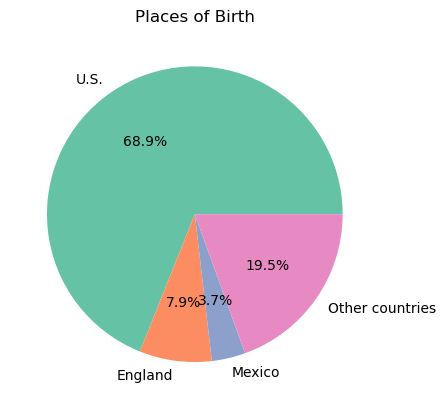

In [142]:
# Create a dataframe with the countries that have the biggest counts and the "Other" category
countries_chart = country_counts_df.head(3)
other_countries_count = country_counts_df.loc[3:, 'Count'].sum()
countries_chart = countries_chart.append({'Country': 'Other countries', 'Count': other_countries_count}, ignore_index=True)

# Set up the colors for the pie chart
colors = sns.color_palette("Set2")

# Set up the pie chart
fig, ax = plt.subplots()
ax.pie(countries_chart['Count'], labels=countries_chart['Country'], autopct='%1.1f%%', colors=colors)

ax.set_title('Places of Birth')

plt.show()

In [143]:
# Top American states by the number of stars born
state_counts = {}

for index, row in df_9.iterrows():
    
    if pd.isna(row['Place of Birth']):
        continue
 
    birthstate = row['Place of Birth'].split(', ')
    if "U.S." in birthstate[-1] or "U.S" in birthstate[-1]:
        state = birthstate[-2].strip()
    else:
        continue
        
    if state in state_counts:
        state_counts[state] += 1
    else:
        state_counts[state] = 1

state_counts['New York'] = state_counts['New York'] + state_counts['New York City']
del state_counts['New York City']

state_counts_df = pd.DataFrame({'American state': list(state_counts.keys()), 'Count': list(state_counts.values())})
state_counts_df = state_counts_df.sort_values('Count', ascending=False)
state_counts_df = state_counts_df.reset_index(drop=True)

state_counts_df.head(10)

,American state,Count
0,New York,31
1,California,13
2,Pennsylvania,9
3,Illinois,9
4,Missouri,8
5,Ohio,6
6,Texas,5
7,Nebraska,5
8,Massachusetts,4
9,New Jersey,4


Visualisation for top-10 state counts:

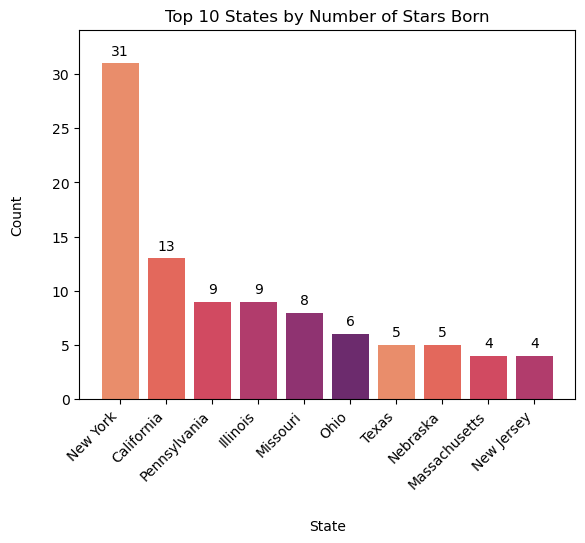

In [144]:
# Extract data for top-10 states
top_10_states = state_counts_df.head(10)
counts = top_10_states['Count']

# Add nice pallette of colors for the histogram using Seaborn library
colors = sns.color_palette("flare")

# Create the histogram
plt.bar(top_10_states['American state'], counts, color=colors)
plt.xlabel('State', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.title('Top 10 States by Number of Stars Born')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for i in range(len(counts)):
    plt.text(x=i, y=counts[i]+0.5, s=counts[i], ha='center', va='bottom', fontsize=10)

# Increase the top limit of y-axis so count values don't the borders
plt.ylim(top=max(counts)*1.1)
    
plt.show()

<li> <i><b> Number of stars born by decade </b></i> </li>

In [145]:
# Top American decades by the number of stars born
decade_counts = {}

for index, row in df_9.iterrows():
    
    if pd.isna(row['Birth Year']):
        continue
 
    year = row['Birth Year']
    
    decade = str(year)[0:-1] + "0s"
    decade
    
    if decade in decade_counts:
        decade_counts[decade] += 1
    else:
        decade_counts[decade] = 1

decade_counts_df = pd.DataFrame({'Decade': list(decade_counts.keys()), 'Count': list(decade_counts.values())})
decade_counts_df = decade_counts_df.sort_values('Count', ascending=False)
decade_counts_df = decade_counts_df.reset_index(drop=True)

decade_counts_df

,Decade,Count
0,1900s,47
1,1920s,36
2,1890s,35
3,1910s,35
4,1930s,18
5,1880s,10
6,1870s,4
7,1860s,2
8,1940s,1


Visualisation:

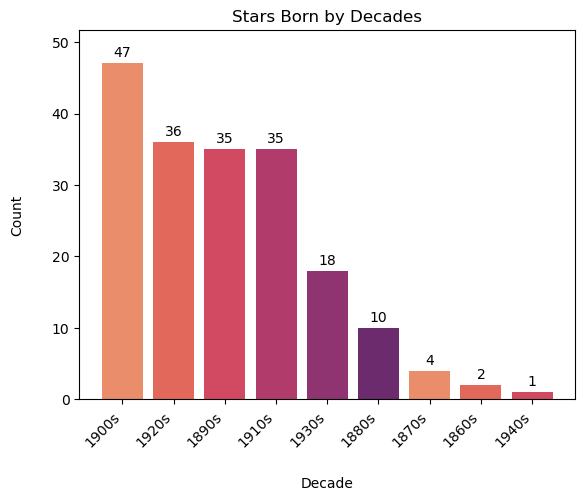

In [146]:
counts = decade_counts_df['Count']

colors = sns.color_palette("flare")

plt.bar(decade_counts_df['Decade'], counts, color=colors)
plt.xlabel('Decade', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.title('Stars Born by Decades')
plt.xticks(rotation=45, ha='right')

for i in range(len(counts)):
    plt.text(x=i, y=counts[i]+0.5, s=counts[i], ha='center', va='bottom', fontsize=10)

plt.ylim(top=max(counts)*1.1)
    
plt.show()

<li> <i><b> Star couples in the list </b></i> </li>

In [147]:
# Let's check how many stars have their spouse(s) in the list
couple_counts = {}

for index, row in df_9.iterrows():

    if pd.isna(row['Spouse/Spouses']):
        continue
 
    person1 = row['Name'].strip()
    spouses_row = row['Spouse/Spouses'].split(", ")
    for e in spouses_row:
        if df['Name'].str.contains(e).any():
            couple_counts[person1] = e
        else:
            continue

# Clean up messy elements
couple_counts = {k: v for k, v in couple_counts.items() if v != '' and v!= 'Jr.'}

# Delete the elements that are dublicates, but in reverse order
couple_counts_cleaned = {}
for k, v in couple_counts.items():
    if v in couple_counts_cleaned and couple_counts_cleaned[v] == k:
        continue
    elif v in couple_counts_cleaned and couple_counts_cleaned[v] != k:
        del couple_counts_cleaned[v]
    else:
        couple_counts_cleaned[k] = v

couple_counts_df = pd.DataFrame({'Spouse 1': list(couple_counts_cleaned.keys()), 'Spouse 2': list(couple_counts_cleaned.values())})
couple_counts_df = couple_counts_df.reset_index(drop=True)

couple_counts_df

,Spouse 1,Spouse 2
0,Douglas Fairbanks,Mary Pickford
1,Wallace Beery,Gloria Swanson
2,William Powell,Carole Lombard
3,Irving Thalberg,Norma Shearer
4,Humphrey Bogart,Lauren Bacall
5,Clark Gable,Carole Lombard
6,David O. Selznick,Jennifer Jones
7,Vincente Minnelli,Judy Garland
8,Joan Crawford,Douglas Fairbanks Jr.
9,The Lord Olivier,Vivien Leigh


<li> <i><b> Proportion of different occupations </b></i> </li>

In [148]:
occup_counts = {}

for index, row in df_9.iterrows():
    
    if pd.isna(row['Occupation/Occupations']):
        continue
  
    occup_list = row['Occupation/Occupations'].strip().split(', ')
    for o in occup_list:
        if o in occup_counts:
            occup_counts[o] += 1
        else:
            occup_counts[o] = 1

occup_counts['actress/actor'] = occup_counts['actress'] + occup_counts['actor']
del occup_counts['actor'], occup_counts['actress']

occup_counts['director'] = occup_counts['director'] + occup_counts['film director'] + occup_counts['filmmaker']
del occup_counts['film director'], occup_counts['filmmaker']

occup_counts['producer'] = occup_counts['producer'] + occup_counts['film producer']
del occup_counts['film producer']

occup_counts['screenwriter'] = occup_counts['screenwriter'] + occup_counts['writer']
del occup_counts['writer']

occup_counts_df = pd.DataFrame({'Occupation': list(occup_counts.keys()), 'Count': list(occup_counts.values())})
occup_counts_df = occup_counts_df.sort_values('Count', ascending=False)
occup_counts_df = occup_counts_df.reset_index(drop=True)

occup_counts_df.head(10)

,Occupation,Count
0,actress/actor,160
1,director,41
2,singer,39
3,producer,38
4,dancer,25
5,screenwriter,23
6,comedian,13
7,model,8
8,activist,5
9,philanthropist,5


Visualization:

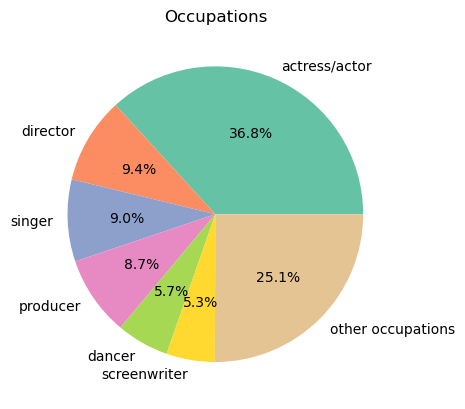

In [149]:
occupation_chart = occup_counts_df.head(6).copy()
other_occup_count = occup_counts_df.loc[6:, 'Count'].sum()
occupation_chart = occupation_chart.append({'Occupation': 'other occupations', 'Count': other_occup_count}, ignore_index=True)

colors = sns.color_palette("Set2")

fig, ax = plt.subplots()
ax.pie(occupation_chart['Count'], labels=occupation_chart['Occupation'], autopct='%1.1f%%', colors=colors)
ax.set_title('Occupations')

plt.show()

# Note: the proportion total doesn't consider the total number of figures, but rather the total occupation count

<li> <i><b> How many stars had more than one occupation? </b></i> </li>

In [150]:
num_occup = 0

for index, row in df_9.iterrows():
    if pd.isna(row['Occupation/Occupations']):
        continue
    occup_list = row['Occupation/Occupations'].strip().split(', ')
    if len(occup_list) > 1:
        num_occup += 1
    else:
        continue
        
print("The number of figures who had more than one occupation: ", num_occup)

The number of figures who had more than one occupation:  116
